## This dataset contains the number of vehicle sales realized in a certain period. The number of sales was kept for every month. We will forecast sales numbers for the next 6 months using MLP.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt;
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
df_cars = pd.read_csv('sales-cars.csv')

Let's see how our dataset looks like.

In [5]:
df_cars.head()

,Month,Sales
0,2016-01,266
1,2016-02,146
2,2016-03,183
3,2016-04,119
4,2016-05,180


In this part, we convert the Month column of the data to date format.

In [7]:
df_cars.index = pd.to_datetime(df_cars.Month, format='%Y-%m')

In [8]:
df_cars = df_cars.resample("M").sum()

In [9]:
df_cars.head()

,Sales
Month,
2016-01-31,266
2016-02-29,146
2016-03-31,183
2016-04-30,119
2016-05-31,180


The sales chart is as follows.

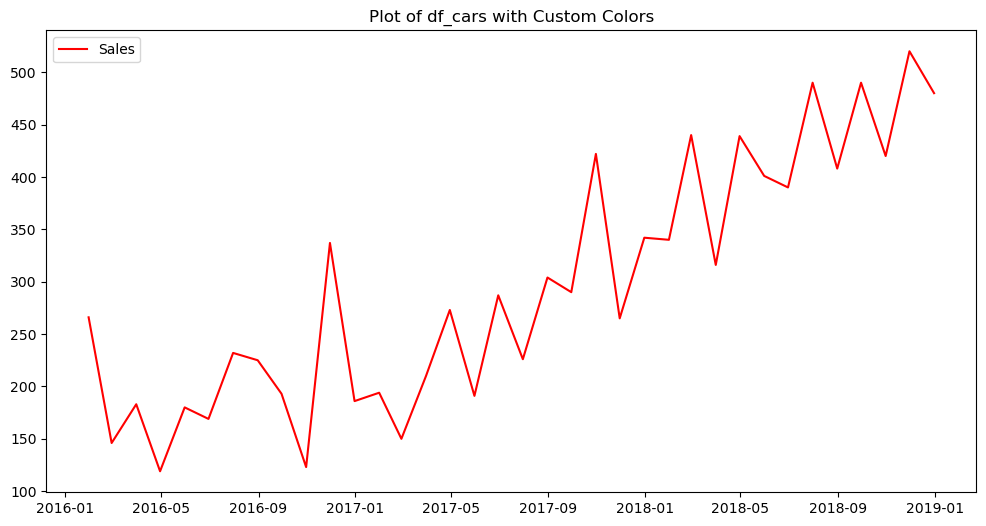

In [83]:
import matplotlib.pyplot as plt

# Assuming df_cars is your DataFrame
custom_colors = ['red', 'green', 'blue', 'orange']  # Add more colors as needed

plt.figure(figsize=(12, 6))

# Plotting each column with custom colors
for i, column in enumerate(df_cars.columns):
    plt.plot(df_cars[column], label=column, color=custom_colors[i % len(custom_colors)])

plt.legend()
plt.title('Plot of df_cars with Custom Colors')
plt.show()


In [11]:
# Seasonal Decompose

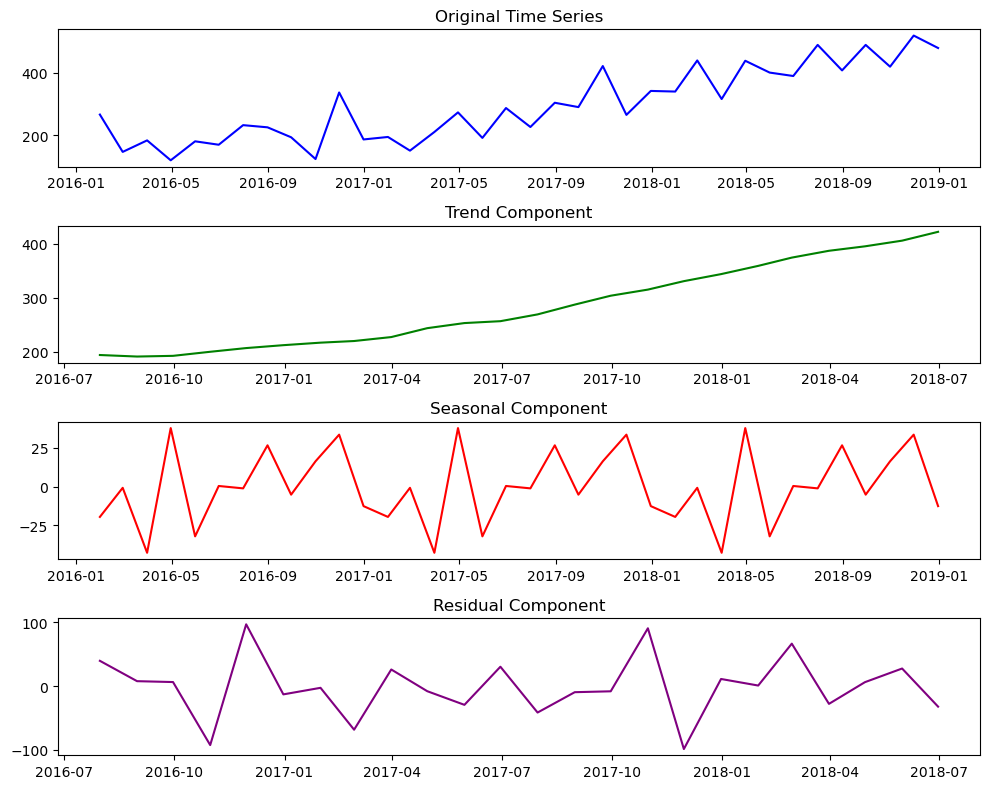

In [81]:
import matplotlib.pyplot as plt

# Assuming 'results' is the seasonal decomposition object
results = seasonal_decompose(df_cars['Sales'])

# Plotting each component with different colors
plt.figure(figsize=(10, 8))

# Original time series
plt.subplot(4, 1, 1)
plt.plot(df_cars['Sales'], color='blue')
plt.title('Original Time Series')

# Trend component
plt.subplot(4, 1, 2)
plt.plot(results.trend, color='green')
plt.title('Trend Component')

# Seasonal component
plt.subplot(4, 1, 3)
plt.plot(results.seasonal, color='red')
plt.title('Seasonal Component')

# Residual component
plt.subplot(4, 1, 4)
plt.plot(results.resid, color='purple')
plt.title('Residual Component')

plt.tight_layout()
plt.show()


**We want to forecast for the next 6 months. However, we will not be able to see how successful the results we produced are, as we do not have actual sales data to compare our predicted results with. Therefore, to measure the success of the forecast, I set aside the last 6 months of the data as test data. I leave the rest as a train. We will predict the next 6 months from the train data and compare it with the real values in the test data.**

In [13]:
# Train Test Split
train = df_cars[:-6]
test = df_cars[-6:]

In [20]:
train.head()

,Sales
Month,
2016-01-31,266
2016-02-29,146
2016-03-31,183
2016-04-30,119
2016-05-31,180


In [21]:
test.head()

,Sales
Month,
2018-07-31,490
2018-08-31,408
2018-09-30,490
2018-10-31,420
2018-11-30,520


In [22]:
# Generate Lags

In [23]:
def generate_lag(df, n):
    X, y = [], []
    for i in range(len(df) - n):
        X.append(df[i:i+n])
        y.append(df[n+i])
    
    return np.array(X), np.array(y), np.array(y[-n:]).reshape(1,n)

In [24]:
X, y, last_batch_values = generate_lag(train.Sales.values, 12)

In [25]:
X

array([[266, 146, 183, 119, 180, 169, 232, 225, 193, 123, 337, 186],
       [146, 183, 119, 180, 169, 232, 225, 193, 123, 337, 186, 194],
       [183, 119, 180, 169, 232, 225, 193, 123, 337, 186, 194, 150],
       [119, 180, 169, 232, 225, 193, 123, 337, 186, 194, 150, 210],
       [180, 169, 232, 225, 193, 123, 337, 186, 194, 150, 210, 273],
       [169, 232, 225, 193, 123, 337, 186, 194, 150, 210, 273, 191],
       [232, 225, 193, 123, 337, 186, 194, 150, 210, 273, 191, 287],
       [225, 193, 123, 337, 186, 194, 150, 210, 273, 191, 287, 226],
       [193, 123, 337, 186, 194, 150, 210, 273, 191, 287, 226, 304],
       [123, 337, 186, 194, 150, 210, 273, 191, 287, 226, 304, 290],
       [337, 186, 194, 150, 210, 273, 191, 287, 226, 304, 290, 422],
       [186, 194, 150, 210, 273, 191, 287, 226, 304, 290, 422, 265],
       [194, 150, 210, 273, 191, 287, 226, 304, 290, 422, 265, 342],
       [150, 210, 273, 191, 287, 226, 304, 290, 422, 265, 342, 340],
       [210, 273, 191, 287, 226, 3

In [26]:
y

array([194, 150, 210, 273, 191, 287, 226, 304, 290, 422, 265, 342, 340,
       440, 316, 439, 401, 390])

In [27]:
last_batch_values

array([[226, 304, 290, 422, 265, 342, 340, 440, 316, 439, 401, 390]])

In [28]:
# Build Model 

# Build the Model

In [29]:
def mlp_model(input_, y_, epochs=1000):
    model = Sequential()
    model.add(Dense(100, activation='relu', input_dim=input_.shape[1]))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    print(model.fit(input_, y_, epochs=epochs))
    return model

In [ ]:
model = mlp_model(X,y, epochs=3000)
model

Epoch 1/3000
1/1 [==============================] - 0s 267ms/step - loss: 151340.2656
Epoch 2/3000
1/1 [==============================] - 0s 3ms/step - loss: 135994.9062
Epoch 3/3000
1/1 [==============================] - 0s 3ms/step - loss: 121663.8203
Epoch 4/3000
1/1 [==============================] - 0s 4ms/step - loss: 108217.3203
Epoch 5/3000
1/1 [==============================] - 0s 4ms/step - loss: 95652.8594
Epoch 6/3000
1/1 [==============================] - 0s 3ms/step - loss: 84088.4609
Epoch 7/3000
1/1 [==============================] - 0s 3ms/step - loss: 73470.6562
Epoch 8/3000
1/1 [==============================] - 0s 3ms/step - loss: 63714.5430
Epoch 9/3000
1/1 [==============================] - 0s 3ms/step - loss: 54794.8555
Epoch 10/3000
1/1 [==============================] - 0s 3ms/step - loss: 46690.2969
Epoch 11/3000
1/1 [==============================] - 0s 4ms/step - loss: 39374.5156
Epoch 12/3000
1/1 [==============================] - 0s 6ms/step - loss: 32866.

# Forecast

In [52]:
def forecast_function(model, last_batch, n):
    in_value = last_batch.copy()
    preds = []
    for i in range(n):
        p = model.predict(in_value)
        preds.append(p.ravel())
        in_value = np.append(in_value, p)[1:].reshape(last_batch.shape)
    return np.array(preds).ravel()

In [53]:
pred = forecast_function(model, last_batch_values, 6)

1/1 [==============================] - 0s 11ms/step


In [54]:
pred

array([424.83197, 511.2947 , 449.2006 , 395.2128 , 496.56677, 497.44608],
      dtype=float32)

In [55]:
test['Predicted_Sales']=pred

In [56]:
test.head()

,Sales,Predicted_Sales
Month,,
2018-07-31,490,424.831970
2018-08-31,408,511.294708
2018-09-30,490,449.200592
2018-10-31,420,395.212799
2018-11-30,520,496.566772


# Show the difference between Sales and Predicted Sales values

<AxesSubplot: xlabel='Month'>

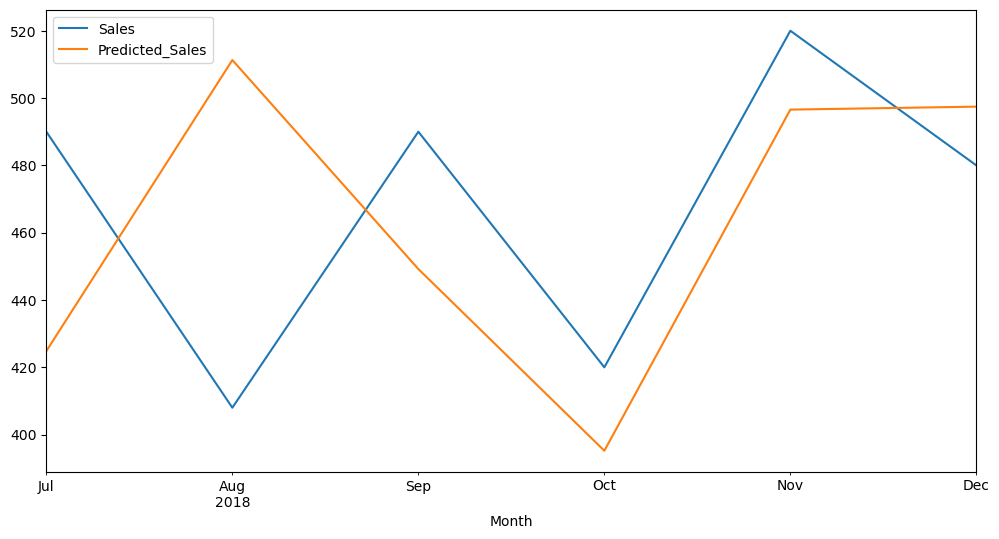

In [57]:
test.plot(figsize=(12,6))

# Calculate error line by line between sales and predicted sales as percentage in test data

In [58]:
def error_function(df,column_1,column_2):
    data = df.copy()
    my_list = []
    for i in range(len(data)):
        x = (data[column_2][i]*100)/data[column_1][i]
        if x >= 100:
            error = x-100
            #data['error_percentage'][i] = error
            my_list.append(error)
        else:
            error = 100-x
            my_list.append(error)
            #data['error_percentage'][i] = error
    data['error_percentage'] = my_list
    return data

In [ ]:
column_1 = 'Sales'
column_2 = 'Predicted_Sales'
df_new = error_function(test,column_1,column_2)

In [ ]:
df_new

# Find the average error

In [59]:
def mean_error(df,error_column):
    total = 0
    for i in range(len(df)):
        total += df[error_column][i]
    mean_error_ = total/(len(df))
    return mean_error_

In [60]:
error_rate = mean_error(df_new,'error_percentage')

In [61]:
error_rate

14.28866722877302

**If we want see how many cars sold in reality, and how much we predicted. Then, we'll find the percentage error.**

In [62]:
sum_of_actual_sales = sum(df_new.Sales.values)

In [63]:
sum_of_actual_sales

2808

In [64]:
sum_of_predicted_sales = sum(df_new.Predicted_Sales.values)

In [65]:
sum_of_predicted_sales

3181.2308044433594

In [66]:
rate_of_actual_and_predict_sums = (sum_of_predicted_sales*100)/sum_of_actual_sales

In [67]:
if rate_of_actual_and_predict_sums >= 100:
    total_percentage = rate_of_actual_and_predict_sums - 100
else:
    total_percentage = 100-rate_of_actual_and_predict_sums

In [68]:
print('Percentage error: ',total_percentage)

Percentage error:  13.291695314934444
